In [19]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy.interpolate
import os
import matplotlib.pyplot as plt
import scipy.interpolate
import matplotlib.gridspec as gridspec
import ctypes
from fatiando.gravmag import transform
import os.path
import matplotlib.image as mpimg

def findPeak(data,alpha): #Open .txt mag data and plot the power spectrum related to certain alpha
    
    #open Mag data
    x,y,mag = np.loadtxt(data, usecols=(0,1,2), unpack = True, delimiter=',') 
    
    #Prepare data to calculate power density spectrum   
    N = int(np.sqrt(len(mag)))       
    shape = (N,N)
    x_grid = np.linspace(x.min(), x.max(), N)
    y_grid = np.linspace(y.min(), y.max(), N)
    xi,yi = np.meshgrid(x_grid,y_grid)
    zi = scipy.interpolate.griddata((x, y), mag,(xi,yi), method='cubic')
    
    #Calculate 2D power spectrum and radial average
    kx, ky, pds = transform.power_density_spectra(xi, yi, zi, shape) 
    k_radial = np.sqrt(kx*kx + ky*ky)
    pds_defractal = pds*(k_radial**alpha) #Defract the observed power density spectrum
    k_radial, pds_radial = transform.radial_average_spectrum(kx, ky, pds_defractal)
    k_radial = k_radial*1000 #Adjust unit from rad/m to rad/km
    
    #Plot radial average
    plt.plot(k_radial,np.log(pds_radial),'-o',c="k")
    plt.grid(lw=.5,c="lightblue")
    plt.title('alpha='+str(alpha))
    plt.xlabel("K radial (rad/km)")
    plt.ylabel("ln(PDS radial)")
    plt.xlim(0,1)
    
def defractal(data,Kzt_min,Kzt_max,Kz0_min,Kz0_max):
    #open Mag data
    x,y,mag = np.loadtxt(data, usecols=(0,1,2), unpack = True, delimiter=',') 
    
    #Prepare data to calculate power density spectrum   
    N = int(np.sqrt(len(mag)))       
    shape = (N,N)
    x_grid = np.linspace(x.min(), x.max(), N)
    y_grid = np.linspace(y.min(), y.max(), N)
    xi,yi = np.meshgrid(x_grid,y_grid)
    zi = scipy.interpolate.griddata((x, y), mag,(xi,yi), method='cubic')
    
    #Calculate 2D power spectrum and radial average
    kx, ky, pds = transform.power_density_spectra(xi, yi, zi, shape) 
    k_radial_centroid, pds_centroid = transform.radial_average_spectrum(kx, ky, pds)
    k_radial_centroid = k_radial_centroid*1000
    
    k_radial_centroid = k_radial_centroid[np.where(k_radial_centroid<=0.8)]
    pds_centroid = pds_centroid[np.where(k_radial_centroid<=0.8)]
    
    alpha = 0
    a_inc = 0.2
    a_lim = 4
    
    xmed = x.min()+(x.max()-x.min())/2
    ymed = y.min()+(y.max()-y.min())/2
    
    zts,zbs,alphas,rmss = [],[],[],[]
    
    with open('table_parameters.txt', "w") as arq:
        arq.write("X Y Zt Zb Alpha RMS\n")
    
    while alpha <= a_lim+a_inc:
        k_radial = np.sqrt(kx*kx + ky*ky)
        pds_defractal = pds*(k_radial**alpha) #Defract the observed power density spectrum
        k_radial, pds_radial = transform.radial_average_spectrum(kx, ky, pds_defractal)
        k_radial = k_radial*1000 #Adjust unit from rad/m to rad/km
        
        k_radial = k_radial[np.where(k_radial <= 0.8)]
        pds_radial = pds_radial[np.where(k_radial <= 0.8)]
        
        #k_radial = np.where((k_radial >= Kzt_min) & (k_radial <= Kzt_max),k_radial,np.nan)
        k_radial_indZt = np.where((k_radial >= Kzt_min) & (k_radial <= Kzt_max))
        k_radial_Zt=k_radial[k_radial_indZt]

        #Fit line using K ranges for Zt
        m, b1 = np.polyfit(k_radial_Zt, np.log(pds_radial)[k_radial_indZt], 1)
        zt = abs(m)/2
        
        k_radial_indZ0 = np.where((k_radial >= Kz0_min) & (k_radial <= Kz0_max))
        k_radial_Z0=k_radial[k_radial_indZ0]
        
        #Fit line using K ranges for Z0
        m, b2 = np.polyfit(k_radial_Z0[1:], 
                np.log(np.sqrt(pds_radial)/k_radial)[k_radial_indZ0][1:], 1)
        z0 = abs(m)
        zb = 2*z0 - zt
        
        #calculate RMS between calculated and modelled
        model = (np.log(np.exp(b1)*((1/np.exp(abs(k_radial)*zt)) - 1/np.exp(abs(k_radial)*zb))**2))
        soma = np.sum((np.log(model[1:])-np.log(pds_radial[1:])**2))
        rms = np.sqrt(soma/len(model))
        
        curva_zt = np.log(pds_radial*(k_radial**alpha))
        curva_z0 = np.log((np.sqrt(pds_radial)/k_radial)*(k_radial**alpha))
        
        #save figure with ln(power) centroid, ln(power) calculated, ln(power) modelled
        plt.plot(k_radial_centroid,np.log(pds_centroid),label = 'Centroid')
        plt.plot(k_radial,np.log(pds_radial),label = 'Defractal')
        plt.plot(k_radial,model,label = 'Model')
        plt.legend()
        plt.xlim(0,1)
        plt.grid(lw=.5,c="lightblue")
        plt.title('alpha='+str(alpha))
        plt.xlabel("K radial (rad/km)")
        plt.ylabel("ln(PDS radial)")
        plt.savefig("alpha%.1f.png"%alpha,dpi=300)        
        zts.append(zt)
        zbs.append(zb)
        alphas.append(alpha)
        rmss.append(rms)
        
        print("Modelling for a = %.1f complete! Figure saved!"%alpha)
        
        alpha +=a_inc
        plt.clf()
        
    #save txt with x,y,zt,zb,alpha,rms  
    with open('table_parameters.txt', "a") as arq:
        for i in range(len(zts)):
            arq.write("%.2f, %.2f, %.2f, %.2f, %.2f, %.2f\n"%(xmed,ymed,zts[i],zbs[i],alphas[i],rmss[i]))
    
    print("Done! Figures and table of parameters saved!")                          

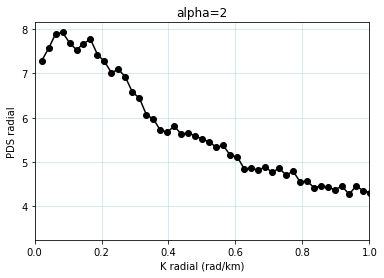

In [23]:
findPeak("window_308.txt",2)

In [20]:
#Define the point position k Range for Zt and Z0
Kzt_min = 0.18
Kzt_max = 0.4
Kz0_min = 0
Kz0_max = 0.15

defractal("window_308.txt",Kzt_min,Kzt_max,Kz0_min,Kz0_max)

Modelling for a = 0.0 complete! Figure saved!
Modelling for a = 0.2 complete! Figure saved!
Modelling for a = 0.4 complete! Figure saved!
Modelling for a = 0.6 complete! Figure saved!
Modelling for a = 0.8 complete! Figure saved!
Modelling for a = 1.0 complete! Figure saved!
Modelling for a = 1.2 complete! Figure saved!
Modelling for a = 1.4 complete! Figure saved!
Modelling for a = 1.6 complete! Figure saved!
Modelling for a = 1.8 complete! Figure saved!
Modelling for a = 2.0 complete! Figure saved!
Modelling for a = 2.2 complete! Figure saved!
Modelling for a = 2.4 complete! Figure saved!
Modelling for a = 2.6 complete! Figure saved!
Modelling for a = 2.8 complete! Figure saved!
Modelling for a = 3.0 complete! Figure saved!
Modelling for a = 3.2 complete! Figure saved!
Modelling for a = 3.4 complete! Figure saved!
Modelling for a = 3.6 complete! Figure saved!
Modelling for a = 3.8 complete! Figure saved!
Modelling for a = 4.0 complete! Figure saved!
Done! Figures and table of paramet

<Figure size 432x288 with 0 Axes>